In [1]:
import numpy as np
import matplotlib.pyplot as plt

from environments.pricing_env import PricingEnvironment
from learners.greedy import Greedy
from learners.ucb import UCB
from learners.normal_gamma_ts import NormalGammaTS

from data_generators.basic_generator import BasicDataGenerator
%matplotlib inline 

In [2]:
data_gen = BasicDataGenerator(filename='src/basic002.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

print(15*'-','DATA', '-'*15)
print(f'{prices=}')
print(f'{bids=}')
print(f'{margins=}')
print(f'{conv_rates=}')
print(f'{costs_per_click=}')
print(f'{n_clicks=}')
print(f'{aggr_tau=}')

sel_bid = 3
print(f'\nSelected bid: {bids[sel_bid]}({sel_bid})')
print(f'Fixed CPC: {costs_per_click[sel_bid]}')
print(f'Fixed num_clicks: {n_clicks[sel_bid]} -> {np.rint(n_clicks[sel_bid]).astype(int)}')

print('\n',15*'-','SIMULATION PARAMS', '-'*15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.03, 0.04, 0.07, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0]
margins=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
conv_rates=array([0.204, 0.211, 0.205, 0.189, 0.176, 0.152, 0.128, 0.113, 0.097,
       0.09 ])
costs_per_click=array([0.03 , 0.04 , 0.069, 0.097, 0.189, 0.44 , 0.626, 0.796, 1.1  ,
       1.367])
n_clicks=array([ 20.018,  26.03 ,  42.358,  56.468,  91.773, 143.8  , 163.133,
       174.226, 185.61 , 190.621])
aggr_tau=array([2.85 , 2.485, 2.12 , 1.755, 1.39 , 1.025, 0.84 , 0.69 , 0.65 ,
       0.65 ])

Selected bid: 0.1(3)
Fixed CPC: 0.097
Fixed num_clicks: 56.468 -> 56

 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [3]:
rewards_per_experiment = {}
rewards_per_experiment['Greedy'] = []
rewards_per_experiment['TS'] = []
rewards_per_experiment['UCB'] = []
daily_rewards_per_experiment = {}
daily_rewards_per_experiment['Greedy'] = []
daily_rewards_per_experiment['TS'] = []
daily_rewards_per_experiment['UCB'] = []

In [4]:
n_arms = len(prices) 
env_params = {
        'n_arms': n_arms,
        'conversion_rates': conv_rates,
        'cost_per_click': costs_per_click[sel_bid],
        'n_clicks': np.rint(n_clicks[sel_bid]).astype(int),
        'margins': margins, 
        'tau': aggr_tau
    }
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    test_instances = [
        ("TS", NormalGammaTS(n_arms), PricingEnvironment(**env_params)),
        ("Greedy", Greedy(n_arms), PricingEnvironment(**env_params)),
        ("UCB", UCB(n_arms), PricingEnvironment(**env_params))
    ]
    
    for t in range(T):
        for name, learner, env in test_instances:
            pulled_arm = learner.pull_arm()
            daily_reward = env.round(pulled_arm)
            for r in daily_reward:
                learner.update(pulled_arm, r)
            #if t % 10 == 0 and name != 'Greedy':
            #    print(f'[exp#{e}] t: {t}\n{name}\n{pulled_arm=}\n{daily_reward=}')
            #    print(30*'-')
    print(f'\n{15*"-"}exp#{e}{15*"-"}\n{test_instances[0][1].mu_0=}, \n{test_instances[0][1].estimated_variance=}, \n{test_instances[0][1].n=},')
    #print(f'\n{15*"-"}exp#{e}{15*"-"}\n{test_instances[0][1].alpha=}, \n{test_instances[0][1].beta=}, \n{test_instances[0][1].mu_0=}, \n{test_instances[0][1].estimated_variance=}, \n{test_instances[0][1].n=},')
    for learner_name, learner, _ in test_instances:
        rewards_per_experiment[learner_name].append(learner.collected_rewards)


---------------exp#0---------------
test_instances[0][1].mu_0=array([11.53025845, 11.40898787, 10.69395749,  9.04060621,  8.41826058,
        5.83501572,  5.3282203 ,  3.42351329,  1.42616817,  3.62973994]), 
test_instances[0][1].estimated_variance=array([561.03999829, 590.09042976, 497.52394865, 421.12925456,
       397.28852825, 236.27888434, 265.99498937, 204.93561793,
        65.03386639, 186.76935881]), 
test_instances[0][1].n=array([3696., 3752., 3192., 2632., 2408., 1232., 1288.,  840.,   56.,
       1344.]),

---------------exp#1---------------
test_instances[0][1].mu_0=array([11.90672498, 11.65473802, 10.18635282,  9.10981988,  7.39872751,
        6.46538619,  4.47359872,  3.69773955,  2.89055626,  1.78670465]), 
test_instances[0][1].estimated_variance=array([607.15254643, 577.38486132, 466.83384032, 450.6583142 ,
       344.67340307, 311.85051636, 196.0634664 , 175.42936924,
       121.70378518, 116.31677615]), 
test_instances[0][1].n=array([4424., 4200., 3976., 2800., 1624.

/home/filippo/anaconda3/envs/dia-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/filippo/anaconda3/envs/dia-env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/filippo/anaconda3/envs/dia-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/filippo/anaconda3/envs/dia-env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


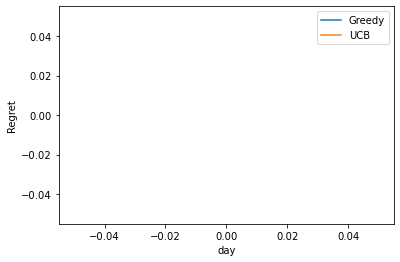

In [5]:
opt_per_round = test_instances[0][2].get_opt()
opt_per_day = opt_per_round * env_params['n_clicks']

#opt = [opt_per_day]*T

# Plotting the results
plt.figure()
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(np.cumsum(np.mean(opt_per_day - daily_rewards_per_experiment['Greedy'], axis=0)))
plt.plot(np.cumsum(np.mean(opt_per_day - daily_rewards_per_experiment['UCB'], axis=0)))
plt.legend(["Greedy", "UCB"])

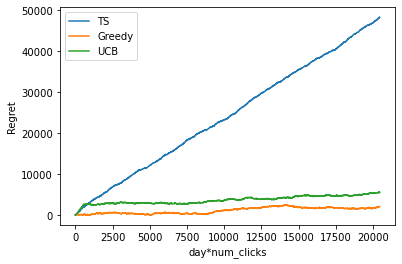

In [8]:
opt_per_round = test_instances[0][2].get_opt()
opt_per_day = opt_per_round * env_params['n_clicks']

# Plotting the results
plt.figure()
plt.ylabel("Regret")
plt.xlabel("day*num_clicks")
plt.plot(np.cumsum(np.mean(opt_per_round - rewards_per_experiment['TS'], axis=0)))
plt.plot(np.cumsum(np.mean(opt_per_round - rewards_per_experiment['Greedy'], axis=0)))
plt.plot(np.cumsum(np.mean(opt_per_round - rewards_per_experiment['UCB'], axis=0)))
plt.legend(["TS", "Greedy", "UCB"])